In [1]:
# Import Packages:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
from six.moves import cPickle as pickle
from six.moves import range
from collections import defaultdict


# Model Packages import
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Get the current working directory
cwd = os.getcwd()
mydir = os.path.abspath(os.path.join(cwd, ".."))
sys.path.append(mydir)
from DataGenerator import genTrainValidFolds


# Packages for plot:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
def reset_graph():  # Reset the graph
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()
    
    
def reshape_data(dataset, labels=None, imageSize=32, numChannels=1, sample_size=None):
    if sample_size:
        dataset = dataset[:sample_size].reshape((-1,imageSize,imageSize,numChannels)) # To reshape the
        # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
        if labels:
            numLabels = len(np.unique(labels))
            labels = (np.arange(numLabels) == labels[:,None]).astype(np.float32)
    else:
        dataset = dataset.reshape((-1,imageSize,imageSize,numChannels)) # To reshape the  
        # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
        if labels:
            numLabels = len(np.unique(labels))
            labels = (np.arange(numLabels) == labels[:,None]).astype(np.float32)
    return dataset, labels

def vizualize(validacc_dict, trainacc_dict, meanValidAcc, rows, columns, figsize=(40,20), xlabels=None, ylabels=None, titles=None):
    fig1, axs = plt.subplots(rows, columns, figsize=figsize, facecolor='w', edgecolor='k')   # 
    axs = axs.ravel()
    numFolds = len(validacc_dict.keys())
    for foldNum in np.arange(numFolds):
        axs[foldNum].plot(validacc_dict[foldNum+1])
        axs[foldNum].plot(trainacc_dict[foldNum+1])
        axs[foldNum].axhline(y=meanValidAcc, color = 'k')
        axs[foldNum].set_title('Validation/Training accuracy Fold:%s '%str(foldNum+1))
        axs[foldNum].legend(['validation acc', 'training acc', ['n-fold avg valid acc']], loc=4)

In [3]:
def accuracy(predictions, labels):
    # Both the predictions and the labels should be in One-Hot vector format.
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])


def confusionMatrix(predictions, labels):
    # Both the predictions and the labels should be in One-Hot vector format.
    return (pd.crosstab(np.argmax(labels, 1), np.argmax(predictions, 1), rownames=['True'], colnames=['Predicted'], margins=True))

# Build the Train, CrossValid and Test Graph:

The below modules build a simple convolutional neural network graph.

In [4]:
class BuildConvNet():
    
    def __init__(self, params):
        self.imageSize = params['imageSize']
        
        
        # NETWORK ARCHITECTURE PARAMETERS
        self.numLabels = params['numLabels']
        self.numChannels = params['numChannels']             # numChannels -> For grayscale =1, for RGB =3
        self.numHidden1 = params['numHidden1']               # numHiddenUnits for the fully connected layerr
        self.numHidden2 = params['numHidden2']               # numHiddenUnits for the fully connected layer

        self.conv1Kernel = params['conv1Kernel']             # Size of kernel for the first convolution layer
        self.conv2Kernel = params['conv2Kernel']             # Size of kernel for the second convolution layer
        self.conv1Depth = params['conv1Depth']               # Number of kernels for the first convolution layer
        self.conv2Depth = params['conv2Depth']               # Number of kernels for the second convolution layer
        self.conv1Stride = params['conv1Stride']             # Strides for the first convolution layer filter  
        self.conv2Stride = params['conv2Stride']             # Strides for the second convolution layer filter

        self.pool1Kernel = params['pool1Kernel']             # Size of kernel for the first Pooling layer
        self.pool2Kernel = params['pool2Kernel']             # Size of kernel for the second Pooling layer  
        self.pool1Stride = params['pool1Stride']             # Strides for the first Pooling layer filter
        self.pool2Stride = params['pool2Stride']             # Strides for the second Pooling layer filter
        
        # BATCH PARAMETERS
        self.epochs = params['epochs']
        self.numFolds = params['numFolds']
        self.batchSize = params['batchSize']
        
        # LEARNING PARAMETERS
        self.keepProb = params['keepProb']
        self.optimizerParam = params['optimizerParam']
        
        # WEIGHTS AND BIASES
        self.weights = {
            'cv1_wght': tf.Variable(tf.random_normal([self.conv1Kernel, self.conv1Kernel, self.numChannels, self.conv1Depth], seed=8753)),
            'cv2_wgth': tf.Variable(tf.random_normal([self.conv2Kernel, self.conv2Kernel, self.conv1Depth, self.conv2Depth], seed=3521)),
            'fc2_wght': tf.Variable(tf.random_normal([self.numHidden1, self.numHidden2], seed=9777)),
            'out_wght': tf.Variable(tf.random_normal([self.numHidden2, self.numLabels], seed=6467))
        }

        self.biases = {
            'cv1_bias': tf.Variable(tf.random_normal([self.conv1Depth], seed=8767)),
            'cv2_bias': tf.Variable(tf.random_normal([self.conv2Depth], seed=9887)),
            'fc1_bias': tf.Variable(tf.random_normal([self.numHidden1], seed=4323)),
            'fc2_bias': tf.Variable(tf.random_normal([self.numHidden2], seed=4348)),
            'out_bias': tf.Variable(tf.random_normal([self.numLabels], seed=9878))
        }


    def convLayer(self, x, w, b, s=1, nlModel='RELU'):
        x = tf.nn.conv2d(x, w, [1,s,s,1], padding='SAME') # Same padding
        x = tf.nn.bias_add(x, b)
        if nlModel == 'RELU':
            return tf.nn.relu(x)
        elif nlModel == 'LOGIT':
            return tf.sigmoid(x)


    def poolLayer(self, x, k=2, s=2, poolType='MAX'):
        if poolType=='MAX':
            return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')
        elif poolType == 'AVG':
            return tf.nn.avg_pool(data, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')

        
    def fcLayer(self, x, w, b, keepProb=None, nModel='RELU'):
        x = tf.matmul(x, w) + b
        if nModel=='RELU':
            x = tf.nn.relu(x)
        if nModel=='LOGIT':
            x = tf.sigmoid(x)
        if keepProb:
            return tf.nn.dropout(x, keepProb, seed=6162)
        else:
            return x
        
        
    def outputLayer(self, x, w, b):
        x = tf.matmul(x, w) + b
        return x, tf.nn.softmax(x)
    
            
    # Convolutional Layer (Includes the convLayer and the max pool layer)
    def convFeatureExtractor(self, x):
        # Convolution and Pooling Layer 1
        conv1 = self.convLayer(x, self.weights['cv1_wght'], self.biases['cv1_bias'], s=self.conv1Stride)
        conv1 = self.poolLayer(conv1, k=self.pool1Kernel)

        # Convolution and Pooling Layer 2
        conv2 = self.convLayer(conv1, self.weights['cv2_wgth'], self.biases['cv2_bias'], self.conv2Stride)
        conv2 = self.poolLayer(conv2, k=self.pool2Kernel)
        
        # Get the features in flattened fashion
        poolShape = conv2.get_shape().as_list()[1]
        numConvFeatures = poolShape*poolShape*self.conv2Depth
        convFeatures = tf.reshape(conv2, [-1, numConvFeatures])
        
        return convFeatures, numConvFeatures
        
        
    # Create the training Graph Lineage
    def trainGraph(self):
        trainData = tf.placeholder(tf.float32, [None, self.imageSize, self.imageSize, self.numChannels])
        trainLabels = tf.placeholder(tf.float32, [None, self.numLabels])

        # Convolutional Layer
        convFeatures, numConvFeatures = self.convFeatureExtractor(trainData)
        
        # Fully connected layer : Reshape conv2 output to fit fully connected layer input
        self.weights['fc1_wght'] =  tf.Variable(tf.random_normal([numConvFeatures, self.numHidden1], seed=6663))
        fc1State = self.fcLayer(convFeatures, self.weights['fc1_wght'], self.biases['fc1_bias'], keepProb=self.keepProb['fc1'], nModel='RELU')  # = 0.5
        
        # Fully connected layer : Layer 2
        fc2State = self.fcLayer(fc1State, self.weights['fc2_wght'], self.biases['fc2_bias'], keepProb=self.keepProb['fc2'], nModel='RELU')  # 0.75

        # Output, or the Softmax layer
        pred, outputState = self.outputLayer(fc2State, self.weights['out_wght'], self.biases['out_bias'])
        
        # Loss function and Optimization
        lossCE = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=trainLabels))
        
        if self.optimizerParam['optimizer'] == 'ADAM':
            optimizer = tf.train.AdamOptimizer(learning_rate=self.optimizerParam['learning_rate']).minimize(lossCE)
        elif self.optimizerParam['optimizer'] == 'RMSPROP':
            optimizer = tf.train.RMSPropOptimizer(learning_rate=self.optimizerParam['learning_rate'], 
                                                  momentum=self.optimizerParam['momentum']).minimize(lossCE)  # 0.0006  # 0.8
        else:
            print ("Your provided optimizers do not match with any of the initialized optimizers: .........")
            return None

        
        return dict(
            trainData=trainData, 
            trainLabels=trainLabels, 
            optimizer=optimizer, 
            lossCE=lossCE,
            trainPred = outputState,
            wghtNew = self.weights
        )
    
    
    # Create the Validation Graph Lineage
    def validGraph(self):

        validData = tf.placeholder(tf.float32, [None, self.imageSize, self.imageSize, self.numChannels])
        validLabels = tf.placeholder(tf.float32, [None, self.numLabels])

        # Convolution and Pooling Layer 1
        vconvFeatures, numConvFeatures = self.convFeatureExtractor(validData)
        
        # Fully connected layer/Hidden Layer 2 : Reshape conv2 output to fit fully connected layer input
        vFc1State = self.fcLayer(vconvFeatures, self.weights['fc1_wght'], self.biases['fc1_bias'], nModel='RELU')
        
        # Fully connected layer/Hidden layer 2
        vFc2State = self.fcLayer(vFc1State, self.weights['fc2_wght'], self.biases['fc2_bias'], nModel='RELU')


        # Output Layer or the softmax layer
        vPred, vOutState = self.outputLayer(vFc2State, self.weights['out_wght'], self.biases['out_bias'])


        return dict(
            validData = validData,
            validLabels = validLabels,
            validPred = vOutState
        )

# Execute the Train, CrossValid and Test graph and evaluate Models:

The below modules executes the graph given the input parameters and provides the training accuracy, validation accuracy and confusion matrix.

In [5]:
class SessionExec():
    
    def __init__(self, featureDIR, params):
        self.featureDIR = featureDIR
        
        self.numFolds = params['numFolds']
        self.epochs = params['epochs']
        self.batchSize = params['batchSize']
        self.imageSize = params['imageSize']
        self.numChannels = params['numChannels']
        
        self.prevWghtDict = {}
        self.wghtChngDict = defaultdict(list)
        self.meanValidAcc = 0
        self.loss_PerEpoch_PerFold = defaultdict(list)
        self.trainacc_PerEpoch_PerFold = defaultdict(list)
        self.validacc_PerEpoch_PerFold = defaultdict(list)
        
        
        
    def captureWghtChange(self, wghtDict):   
        for layer, wght_arr in wghtDict.items():
#             print (layer)
#             print (np.sum(np.abs(wght_arr-self.prevWghtDict[layer])))
#             print ('********************')
            self.wghtChngDict[layer].append(np.sum(np.abs(wght_arr-self.prevWghtDict[layer])))
    
    
    
    def trainModel(self, trainDataIN, trainLabelsIN, sess):    
        numBatches = int(trainDataIN.shape[0]/self.batchSize)
        for numBatch in np.arange(numBatches):
#                     print ('Batch no: ', numBatch)
#                     print (numBatch*self.batchSize,  (numBatch+1)*self.batchSize)
            batchData = trainDataIN[numBatch*self.batchSize : (numBatch+1)*self.batchSize]
            batchLabels = trainLabelsIN[numBatch*self.batchSize : (numBatch+1)*self.batchSize]

            feed_dict = {self.trainGraphDict['trainData']: batchData,
                         self.trainGraphDict['trainLabels']: batchLabels
#                              self.trainGraphDict['keep_prob']: 0.7
                    }

            _, loss, tpred, wght = sess.run([self.trainGraphDict['optimizer'],
                                        self.trainGraphDict['lossCE'],
                                        self.trainGraphDict['trainPred'],
                                        self.trainGraphDict['wghtNew']], feed_dict=feed_dict)
            
            if any(self.prevWghtDict):
                self.captureWghtChange(wght)
                self.prevWghtDict = wght
            else:
                self.prevWghtDict = wght
                
                
            if ((numBatch+1)%10 == 0) or ((numBatch+1) == numBatches): 
                tacc = accuracy(tpred, batchLabels)
                print ("Fold: " + str(self.foldNUM+1) + 
                       ", Epoch: " + str(self.epoch+1)+ 
                       ", Mini Batch: " + str(numBatch+1) + 
                       ", Loss= " + "{:.6f}".format(loss) + 
                       ", Training Accuracy= " + "{:.5f}".format(tacc))
    
        return loss, tacc
    
    
    def validModel(self, validDataIN, validLabelsIN, sess):
        feed_dict = {self.validGraphDict['validData']: validDataIN,
                     self.validGraphDict['validLabels']: validLabelsIN
#                              self.trainGraphDict['keep_prob']: 0.7
                }

        vpred = sess.run(self.validGraphDict['validPred'], feed_dict=feed_dict)
        
        vacc = accuracy(vpred, validLabelsIN)
        print ("Fold: " + str(self.foldNUM+1) + 
                ", Epoch: " + str(self.epoch+1)+ 
                ", Validation Accuracy= " + "{:.5f}".format(vacc))
        
        return vpred, vacc 
        
        
    def execute(self):
        meanValidAcc = 0
        
        for foldNUM, (trainDataIN, trainLabelsIN, validDataIN, validLabelsIN, labelDict) in enumerate(genTrainValidFolds(self.featureDIR, oneHot=True)):   
            print ('')
            print ('##########################################################################################')
            trainDataIN, _ = reshape_data(trainDataIN, imageSize=self.imageSize, numChannels=self.numChannels)                                       
            validDataIN, _ = reshape_data(validDataIN, imageSize=self.imageSize, numChannels=self.numChannels)
            
            print ('')
            print ('Validation Data and Labels shape: ', validDataIN.shape, validLabelsIN.shape)
            print ('Training Data and Labels shape: ', trainDataIN.shape, trainLabelsIN.shape)
            print ('The Label Dictionary is given as: ', labelDict)
            print ('')
            
            self.foldNUM = foldNUM

            reset_graph()

            # Create a object encapsulating the graph lineage
            objCNN = BuildConvNet(params)
            self.trainGraphDict = objCNN.trainGraph()
            self.validGraphDict = objCNN.validGraph()
            
            with tf.Session() as sess:
                sess.run(tf.initialize_all_variables())

                for epoch in range(self.epochs): 
                    self.epoch = epoch
                    
                    # Train The model for Epochs
                    loss, tacc = self.trainModel(trainDataIN, trainLabelsIN, sess)
                    print ('')
                    
                    # Validate the model for Epochs
                    vpred, vacc = self.validModel(validDataIN, validLabelsIN, sess)
                    print ('')
                    
                    self.loss_PerEpoch_PerFold[foldNUM+1].append(loss)
                    self.trainacc_PerEpoch_PerFold[foldNUM+1].append(tacc)
                    self.validacc_PerEpoch_PerFold[foldNUM+1].append(vacc)
                    
                    if (epoch+1)%10 ==0 or ((epoch+1) == self.epochs):
                        validCM = confusionMatrix(validLabelsIN,vpred)
                        print ('Confusion Matrix CrossValid Set')
                        print (validCM)
                        print ('')
            
            self.meanValidAcc += vacc
            
            if foldNUM == self.numFolds-1:
                break
                
        return (self.wghtChngDict, 
                self.meanValidAcc/self.numFolds, 
                self.loss_PerEpoch_PerFold, 
                self.trainacc_PerEpoch_PerFold, 
                self.validacc_PerEpoch_PerFold)
                
  

# MODEL 1: Standarized Feature Set with ADAM Optimizer

In [6]:
STDbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model/STD/batchData/"
EDGbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model/EDG/batchData/"
HOGp1batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model/HOGp1/batchData/"   # dim =162
HOGp2batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model/HOGp2/batchData/"   # dim =576
HOGp3batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model/HOGp3/batchData/"

featureDIR = STDbatch_dir

params = dict(imageSize = 32,
              seed = 2316,                 # Set the seeds for the random weights generator
              numFolds = 1,
              
              # Network Parameters
              numLabels = 2,
              numChannels = 1,             # numChannels -> For grayscale =1, for RGB =3
              numHidden1 = 1024,           # numHiddenUnits for the fully connected layerr
              numHidden2 = 1024,            # numHiddenUnits for the fully connected layer
              
              conv1Kernel = 5,             # Size of kernel for the first convolution layer
              conv2Kernel = 5,             # Size of kernel for the second convolution layer
              conv1Depth = 64,             # Number of kernels for the first convolution layer
              conv2Depth = 64,             # Number of kernels for the second convolution layer
              conv1Stride = 1,             # Strides for the first convolution layer filter  
              conv2Stride = 1,             # Strides for the second convolution layer filter
              
              pool1Kernel = 2,             # Size of kernel for the first Pooling layer
              pool2Kernel = 2,             # Size of kernel for the second Pooling layer  
              pool1Stride = 2,             # Strides for the first Pooling layer filter
              pool2Stride = 2,             # Strides for the second Pooling layer filter
              
              # Learning Variables     
              epochs = 20,
              batchSize = 500,
        
              keepProb = dict(fc1=0.5, fc2=0.7),
#               optimizerParam = dict(optimizer='RMSPROP', learning_rate=0.0008, momentum=0.8)
              optimizerParam = dict(optimizer='ADAM', learning_rate=0.003)  # at 0.003 descents slowely, 
        )

# print (params)

(out, meanValidAcc, lossPerEpochPerFold, taccPerEpochPerFold, vaccPerEpochPerFold) = SessionExec(featureDIR, params).execute() 

print ('The mean Valid Accuracy is : ', meanValidAcc)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model/STD/batchData/'

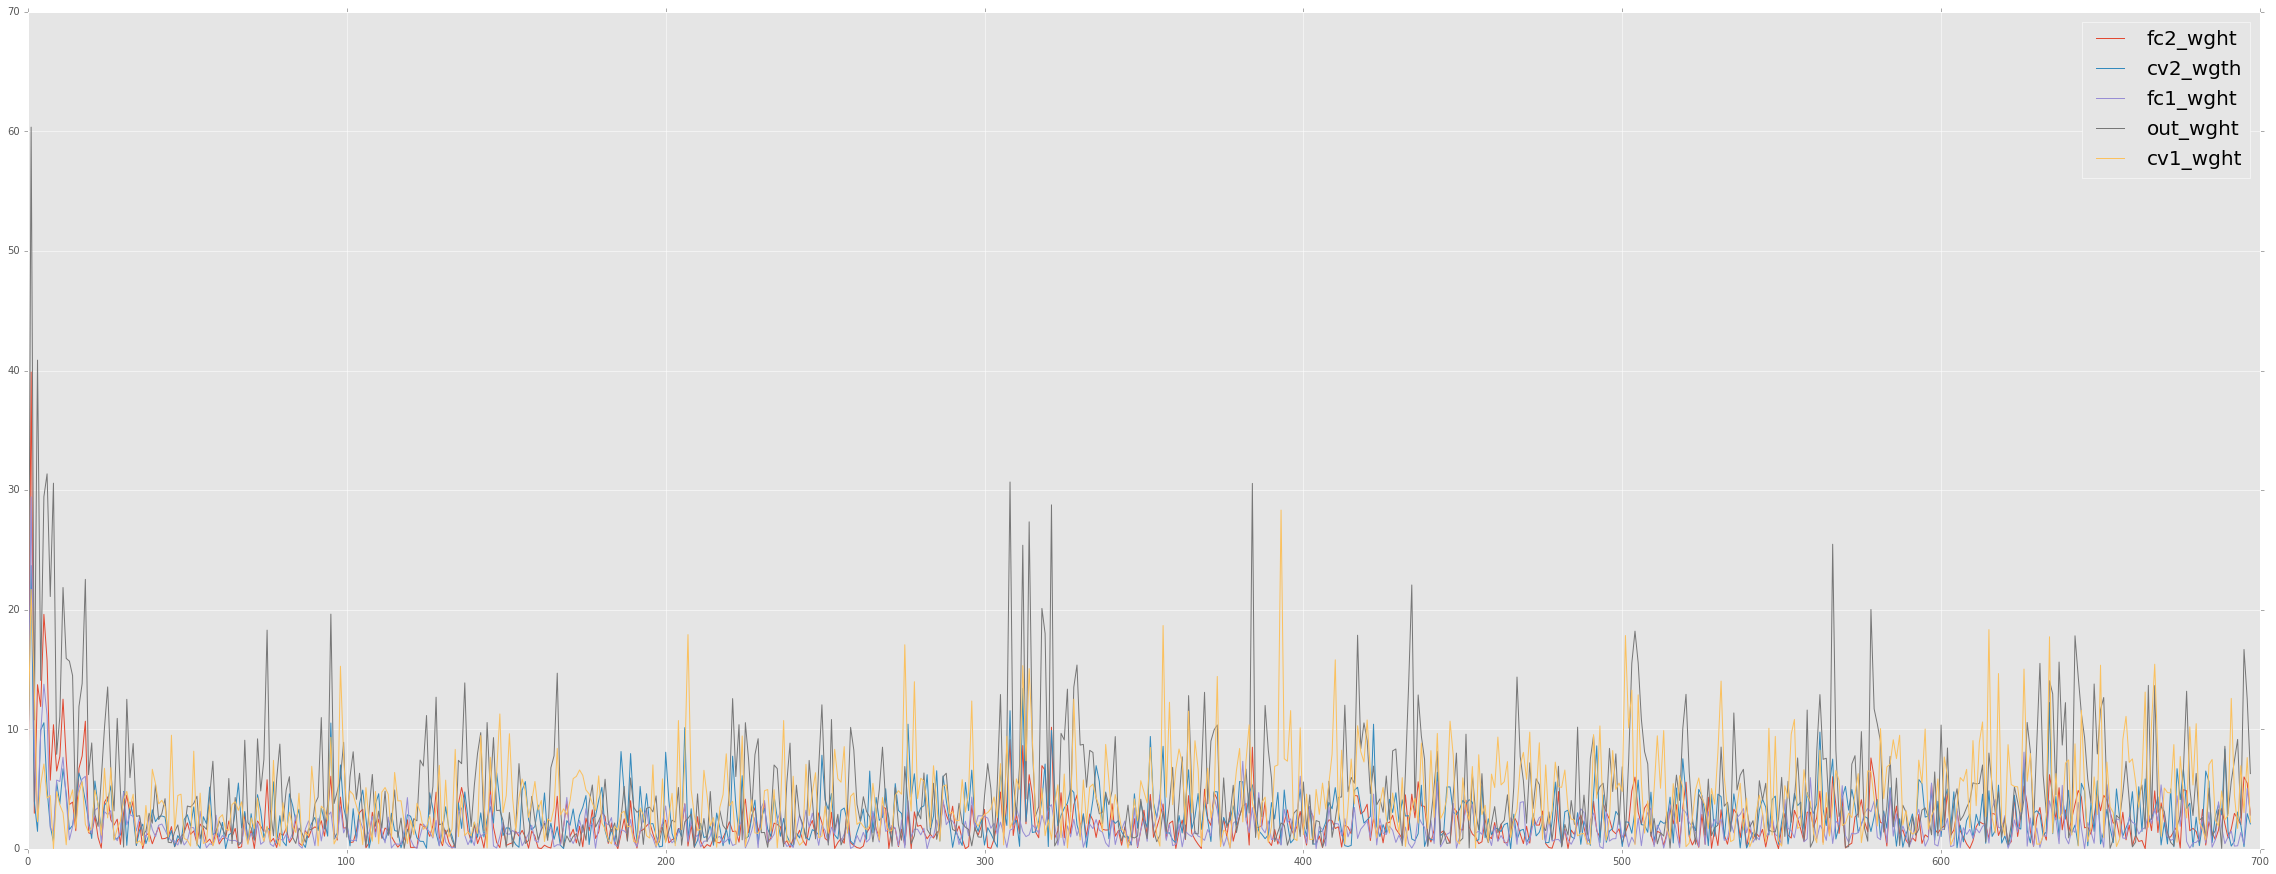

In [7]:
ax = plt.figure(figsize=(40,15), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]], dtype=float32)

# Model 2: With RMSPROP Optimizer

In [7]:
STDbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/STD/batchData/"
EDGbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/EDG/batchData/"
HOGp1batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp1/batchData/"   # dim =162
HOGp2batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp2/batchData/"   # dim =576
HOGp3batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp3/batchData/"

featureDIR = STDbatch_dir

params = dict(imageSize = 32,
              seed = 2316,                 # Set the seeds for the random weights generator
              numFolds = 1,
              
              # Network Parameters
              numLabels = 2,
              numChannels = 1,             # numChannels -> For grayscale =1, for RGB =3
              numHidden1 = 1024,           # numHiddenUnits for the fully connected layerr
              numHidden2 = 1024,            # numHiddenUnits for the fully connected layer
              
              conv1Kernel = 5,             # Size of kernel for the first convolution layer
              conv2Kernel = 5,             # Size of kernel for the second convolution layer
              conv1Depth = 64,             # Number of kernels for the first convolution layer
              conv2Depth = 64,             # Number of kernels for the second convolution layer
              conv1Stride = 1,             # Strides for the first convolution layer filter  
              conv2Stride = 1,             # Strides for the second convolution layer filter
              
              pool1Kernel = 2,             # Size of kernel for the first Pooling layer
              pool2Kernel = 2,             # Size of kernel for the second Pooling layer  
              pool1Stride = 2,             # Strides for the first Pooling layer filter
              pool2Stride = 2,             # Strides for the second Pooling layer filter
              
              # Learning Variables     
              epochs = 20,
              batchSize = 256,
        
              keepProb = dict(fc1=0.75, fc2=0.75),
              optimizerParam = dict(optimizer='RMSPROP', learning_rate=0.0006, momentum=0.8)
#               optimizerParam = dict(optimizer='ADAM', learning_rate=0.003)  # at 0.003 descents slowely, 
        )
(out, meanValidAcc, lossPerEpochPerFold, taccPerEpochPerFold, vaccPerEpochPerFold) = SessionExec(featureDIR, params).execute() 

print ('The mean Valid Accuracy is : ', meanValidAcc)


##########################################################################################

Validation Data and Labels shape:  (1000, 32, 32, 1) (1000, 2)
Training Data and Labels shape:  (9000, 32, 32, 1) (9000, 2)
The Label Dictionary is given as:  {0: 'trainDataAirplane.pickle', 1: 'trainDataCat.pickle'}

Fold: 1, Epoch: 1, Mini Batch: 10, Loss= 313737.125000, Training Accuracy= 70.70312
Fold: 1, Epoch: 1, Mini Batch: 20, Loss= 129066.210938, Training Accuracy= 77.34375
Fold: 1, Epoch: 1, Mini Batch: 30, Loss= 106755.007812, Training Accuracy= 75.39062
Fold: 1, Epoch: 1, Mini Batch: 35, Loss= 79962.156250, Training Accuracy= 80.07812

Fold: 1, Epoch: 1, Validation Accuracy= 78.70000

Fold: 1, Epoch: 2, Mini Batch: 10, Loss= 59639.917969, Training Accuracy= 81.64062
Fold: 1, Epoch: 2, Mini Batch: 20, Loss= 48298.476562, Training Accuracy= 79.68750
Fold: 1, Epoch: 2, Mini Batch: 30, Loss= 38176.960938, Training Accuracy= 80.07812
Fold: 1, Epoch: 2, Mini Batch: 35, Loss= 32092.476562,

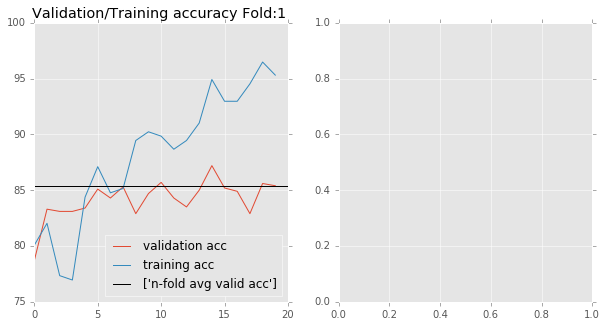

In [9]:
rows = 1
columns = 2
vizualize(vaccPerEpochPerFold, taccPerEpochPerFold, meanValidAcc=meanValidAcc, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

In [10]:
STDbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/STD/batchData/"
EDGbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/EDG/batchData/"
HOGp1batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp1/batchData/"   # dim =162
HOGp2batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp2/batchData/"   # dim =576
HOGp3batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp3/batchData/"

featureDIR = STDbatch_dir

params = dict(imageSize = 32,
              seed = 2316,                 # Set the seeds for the random weights generator
              numFolds = 1,
              
              # Network Parameters
              numLabels = 2,
              numChannels = 1,             # numChannels -> For grayscale =1, for RGB =3
              numHidden1 = 1024,           # numHiddenUnits for the fully connected layerr
              numHidden2 = 1024,            # numHiddenUnits for the fully connected layer
              
              conv1Kernel = 5,             # Size of kernel for the first convolution layer
              conv2Kernel = 5,             # Size of kernel for the second convolution layer
              conv1Depth = 64,             # Number of kernels for the first convolution layer
              conv2Depth = 64,             # Number of kernels for the second convolution layer
              conv1Stride = 1,             # Strides for the first convolution layer filter  
              conv2Stride = 1,             # Strides for the second convolution layer filter
              
              pool1Kernel = 2,             # Size of kernel for the first Pooling layer
              pool2Kernel = 2,             # Size of kernel for the second Pooling layer  
              pool1Stride = 2,             # Strides for the first Pooling layer filter
              pool2Stride = 2,             # Strides for the second Pooling layer filter
              
              # Learning Variables     
              epochs = 20,
              batchSize = 256,
        
              keepProb = dict(fc1=0.7, fc2=0.7),
              optimizerParam = dict(optimizer='RMSPROP', learning_rate=0.0002, momentum=0.9)
#               optimizerParam = dict(optimizer='ADAM', learning_rate=0.003)  # at 0.003 descents slowely, 
        )

# print (params)

(out, meanValidAcc, lossPerEpochPerFold, taccPerEpochPerFold, vaccPerEpochPerFold) = SessionExec(featureDIR, params).execute() 

print ('The mean Valid Accuracy is : ', meanValidAcc)


##########################################################################################

Validation Data and Labels shape:  (1000, 32, 32, 1) (1000, 2)
Training Data and Labels shape:  (9000, 32, 32, 1) (9000, 2)
The Label Dictionary is given as:  {0: 'trainDataAirplane.pickle', 1: 'trainDataCat.pickle'}

Fold: 1, Epoch: 1, Mini Batch: 10, Loss= 541352.000000, Training Accuracy= 60.54688
Fold: 1, Epoch: 1, Mini Batch: 20, Loss= 278523.125000, Training Accuracy= 67.18750
Fold: 1, Epoch: 1, Mini Batch: 30, Loss= 233123.171875, Training Accuracy= 69.53125
Fold: 1, Epoch: 1, Mini Batch: 35, Loss= 208801.093750, Training Accuracy= 71.09375

Fold: 1, Epoch: 1, Validation Accuracy= 80.30000

Fold: 1, Epoch: 2, Mini Batch: 10, Loss= 148387.031250, Training Accuracy= 74.60938
Fold: 1, Epoch: 2, Mini Batch: 20, Loss= 116600.898438, Training Accuracy= 75.78125
Fold: 1, Epoch: 2, Mini Batch: 30, Loss= 85433.031250, Training Accuracy= 73.82812
Fold: 1, Epoch: 2, Mini Batch: 35, Loss= 76028.3437

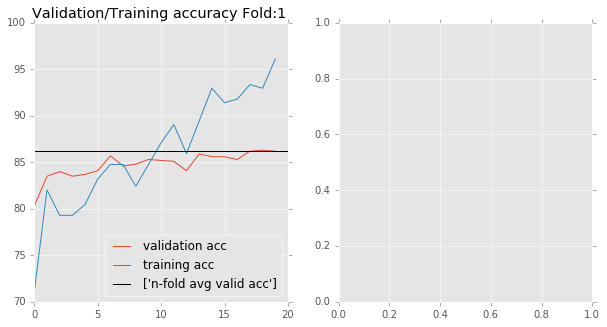

In [11]:
rows = 1
columns = 2
vizualize(vaccPerEpochPerFold, taccPerEpochPerFold, meanValidAcc=meanValidAcc, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

In [6]:
STDbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/STD/batchData/"
EDGbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/EDG/batchData/"
HOGp1batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp1/batchData/"   # dim =162
HOGp2batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp2/batchData/"   # dim =576
HOGp3batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp3/batchData/"

featureDIR = STDbatch_dir

params = dict(imageSize = 32,
              seed = 2316,                 # Set the seeds for the random weights generator
              numFolds = 1,
              
              # Network Parameters
              numLabels = 2,
              numChannels = 1,             # numChannels -> For grayscale =1, for RGB =3
              numHidden1 = 1024,           # numHiddenUnits for the fully connected layerr
              numHidden2 = 1024,            # numHiddenUnits for the fully connected layer
              
              conv1Kernel = 5,             # Size of kernel for the first convolution layer
              conv2Kernel = 5,             # Size of kernel for the second convolution layer
              conv1Depth = 64,             # Number of kernels for the first convolution layer
              conv2Depth = 64,             # Number of kernels for the second convolution layer
              conv1Stride = 1,             # Strides for the first convolution layer filter  
              conv2Stride = 1,             # Strides for the second convolution layer filter
              
              pool1Kernel = 2,             # Size of kernel for the first Pooling layer
              pool2Kernel = 2,             # Size of kernel for the second Pooling layer  
              pool1Stride = 2,             # Strides for the first Pooling layer filter
              pool2Stride = 2,             # Strides for the second Pooling layer filter
              
              # Learning Variables     
              epochs = 20,
              batchSize = 256,
        
              keepProb = dict(fc1=0.6, fc2=0.75),
              optimizerParam = dict(optimizer='RMSPROP', learning_rate=0.0004, momentum=0.8)
#               optimizerParam = dict(optimizer='ADAM', learning_rate=0.003)  # at 0.003 descents slowely, 
        )

# print (params)

(out, meanValidAcc, lossPerEpochPerFold, taccPerEpochPerFold, vaccPerEpochPerFold) = SessionExec(featureDIR, params).execute() 

print ('The mean Valid Accuracy is : ', meanValidAcc)


##########################################################################################

Validation Data and Labels shape:  (1000, 32, 32, 1) (1000, 2)
Training Data and Labels shape:  (9000, 32, 32, 1) (9000, 2)
The Label Dictionary is given as:  {0: 'trainDataAirplane.pickle', 1: 'trainDataCat.pickle'}

Fold: 1, Epoch: 1, Mini Batch: 10, Loss= 384481.968750, Training Accuracy= 67.18750
Fold: 1, Epoch: 1, Mini Batch: 20, Loss= 210827.531250, Training Accuracy= 75.78125
Fold: 1, Epoch: 1, Mini Batch: 30, Loss= 181360.843750, Training Accuracy= 76.56250
Fold: 1, Epoch: 1, Mini Batch: 35, Loss= 163379.453125, Training Accuracy= 74.60938

Fold: 1, Epoch: 1, Validation Accuracy= 80.40000

Fold: 1, Epoch: 2, Mini Batch: 10, Loss= 129622.687500, Training Accuracy= 75.78125
Fold: 1, Epoch: 2, Mini Batch: 20, Loss= 114431.015625, Training Accuracy= 77.34375
Fold: 1, Epoch: 2, Mini Batch: 30, Loss= 101591.921875, Training Accuracy= 72.65625
Fold: 1, Epoch: 2, Mini Batch: 35, Loss= 71554.734

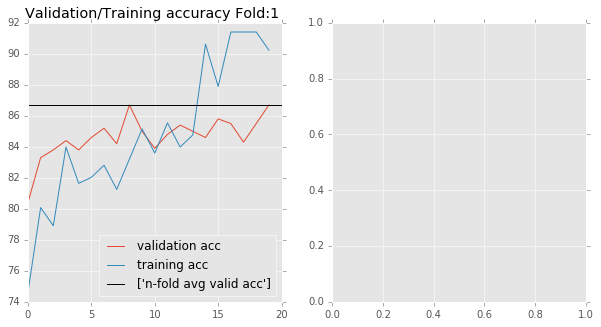

In [7]:
rows = 1
columns = 2
vizualize(vaccPerEpochPerFold, taccPerEpochPerFold, meanValidAcc=meanValidAcc, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

# Model 3: ZCA-Whitening and RMSPROP

In [1]:
ZCAbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/ZCA/batchData/"
STDbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/STD/batchData/"
EDGbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/EDG/batchData/"
HOGp1batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp1/batchData/"   # dim =162
HOGp2batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp2/batchData/"   # dim =576
HOGp3batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp3/batchData/"

featureDIR = ZCAbatch_dir

params = dict(imageSize = 32,
              seed = 2316,                 # Set the seeds for the random weights generator
              numFolds = 1,
              
              # Network Parameters
              numLabels = 2,
              numChannels = 1,             # numChannels -> For grayscale =1, for RGB =3
              numHidden1 = 1024,           # numHiddenUnits for the fully connected layerr
              numHidden2 = 1024,            # numHiddenUnits for the fully connected layer
              
              conv1Kernel = 5,             # Size of kernel for the first convolution layer
              conv2Kernel = 5,             # Size of kernel for the second convolution layer
              conv1Depth = 64,             # Number of kernels for the first convolution layer
              conv2Depth = 64,             # Number of kernels for the second convolution layer
              conv1Stride = 1,             # Strides for the first convolution layer filter  
              conv2Stride = 1,             # Strides for the second convolution layer filter
              
              pool1Kernel = 2,             # Size of kernel for the first Pooling layer
              pool2Kernel = 2,             # Size of kernel for the second Pooling layer  
              pool1Stride = 2,             # Strides for the first Pooling layer filter
              pool2Stride = 2,             # Strides for the second Pooling layer filter
              
              # Learning Variables     
              epochs = 20,
              batchSize = 500,
        
              keepProb = dict(fc1=0.7, fc2=0.7),
              optimizerParam = dict(optimizer='RMSPROP', learning_rate=0.0004, momentum=0.8)
#               optimizerParam = dict(optimizer='ADAM', learning_rate=0.006)  # at 0.003 descents slowely, 
        )

# print (params)

(out, meanValidAcc, lossPerEpochPerFold, taccPerEpochPerFold, vaccPerEpochPerFold) = SessionExec(featureDIR, params).execute() 

print ('The mean Valid Accuracy is : ', meanValidAcc)

NameError: name 'SessionExec' is not defined